**This notebook is dedicated on the detection of fake news. We use the attention-based encoder part of the Transformer and the linguistic features of news content to classify the fake news** 

**Reference:**
- Model: Encoder-Transformer [ https://github.com/tensorflow/models/tree/master/official/transformer ]
- Dataset: politifact [ https://github.com/KaiDMML/FakeNewsNet ]


# Data Processing

In [1]:
import os
import glob
import json
import time
import collections
from utils import tokenizer
import tensorflow as tf
import numpy as np

### Read fake news dataset

In [2]:
data_dir = "./dataset/politifact/"

fake_files = glob.glob(os.path.join(data_dir, "fake/*/*.json"))
real_files = glob.glob(os.path.join(data_dir, "real/*/*.json"))

# split 80-20 for training/testing
train_fake_files = fake_files[:int(0.8*len(fake_files))]
test_fake_files = fake_files[int(0.8*len(fake_files)):]
train_real_files = real_files[:int(0.8*len(real_files))]
test_real_files = real_files[int(0.8*len(real_files)):]

## print info
print(" Training: %d news (%d fake + %d real) " %(len(train_fake_files+train_real_files), 
                                                   len(train_fake_files) , len(train_real_files)))

print(" Testing: %d news (%d fake + %d real) " %(len(test_fake_files+test_real_files), 
                                                   len(test_fake_files) , len(test_real_files)))

 Training: 776 news (324 fake + 452 real) 
 Testing: 195 news (81 fake + 114 real) 


### BPE encoding

In [3]:
# Generate subword vocabulary
_TARGET_VOCAB_SIZE = 32768  # Number of subtokens in the vocabulary list.
_TARGET_THRESHOLD = 327  # Accept vocabulary if size is within this threshold
VOCAB_FILE = "vocab.ende.%d" % _TARGET_VOCAB_SIZE # name of vocabulary

# minimum number of times a subtoken must appear before it is added to the vocabulary.
_TRAIN_DATA_MIN_COUNT = 6

# directory to save the vocabulary
vocab_file = os.path.join(data_dir, VOCAB_FILE)

# generate subtoken vocabulary from training files
subtokenizer = tokenizer.Subtokenizer.init_from_files(
      vocab_file, train_fake_files + train_real_files, _TARGET_VOCAB_SIZE, _TARGET_THRESHOLD,
      min_count=_TRAIN_DATA_MIN_COUNT)

INFO:tensorflow:Begin steps to create subtoken vocabulary...
INFO:tensorflow:Using min_count=6 to generate vocab with target size 32768
INFO:tensorflow:	Generating subtokens: iteration 0
INFO:tensorflow:	Vocab size: 42351
INFO:tensorflow:	Generating subtokens: iteration 1
INFO:tensorflow:	Vocab size: 17088
INFO:tensorflow:	Generating subtokens: iteration 2
INFO:tensorflow:	Vocab size: 17468
INFO:tensorflow:	Generating subtokens: iteration 3
INFO:tensorflow:	Vocab size: 17376
INFO:tensorflow:Generated vocabulary with 17376 subtokens.
INFO:tensorflow:Initializing Subtokenizer from file ./dataset/politifact/vocab.ende.32768.


In [4]:
# Load vocabulary
vocab = tokenizer.Subtokenizer(vocab_file)

INFO:tensorflow:Initializing Subtokenizer from file ./dataset/politifact/vocab.ende.32768.


#### Example encoding and decoding using BPE

In [5]:
with open(test_fake_files[38], 'r') as f:
    text = json.load(f)["text"]
    print(" -- Text -- ")
    print(text)
    print(" -- Encoding -- ")
    encode = vocab.encode(text, add_eos=False)
    print(encode)
    print(" -- Decoding -- ")
    decode = vocab.decode(encode)
    print(decode)

 -- Text -- 
Whoopi Goldberg is in hot water after comments she made Wednesday regarding the Navy SEAL widow that was honored last night during President Donald Trump’s historical speech.

“She was just looking for attention. These military widows love their 15 minutes in the spotlight”, Goldberg said.

“If it were me I wouldn’t be able to leave the house. How can someone who is truly greiving go out there and be on TV. It just doesn’t make sense to me”

After last night’s demonstration where several democrats in leadership roles refused to stand while the widow was being honored, Goldberg continues to make the point that liberals lack a significant amount of class.

*** UPDATE- Anyone who believes this story or any other story on this website needs to read this post ***

.
 -- Encoding -- 
[7350, 5680, 3660, 25, 7442, 8548, 15, 11, 4689, 1649, 207, 1329, 146, 195, 2024, 2270, 3, 1827, 13742, 1095, 6236, 4875, 8, 36, 4337, 203, 864, 393, 124, 446, 163, 22, 12, 7210, 692, 617, 384, 36, 

### Encode the training dataset and testing dataset as the input of the attention model.
- We add special token "EOS" at the beginning of each news. The output of "EOS" token will be used for the classification.

In [6]:
""" Training """
# source news
src_train_files = train_fake_files + train_real_files
src_train = []
for file in src_train_files:
    with open(file, 'r') as f:
        text = json.load(f)["text"]
        src_train.append(vocab.encode(text, add_eos=True))
# target labels
tgt_train = [[0]]*len(train_fake_files) + [[1]]*len(train_real_files)

In [7]:
""" Testing """
# source news
src_test_files = test_fake_files + test_real_files
src_test = []
for file in src_test_files:
    with open(file, 'r') as f:
        text = json.load(f)["text"]
        src_test.append(vocab.encode(text, add_eos=True))
# target labels
tgt_test = [0]*len(test_fake_files) + [1]*len(test_real_files)

# padding function to create test iterator during inference
def padding_infer_set(infer_set):
    """
        input: [[1,2], [3,4,5]]
        return: [[1,2,0], [3,4,5]]
    """
    infer_len = [len(x) for x in infer_set]
    padded_infer_set = [list(np.pad(x_, pad_width=((0,max(infer_len)-len(x_))), mode='constant', constant_values=0)) for x_ in infer_set]
    return padded_infer_set

# Attention Model for Fake News Detections

### Import modules

In [8]:
from model import attention_layer
from model import beam_search
from model import embedding_layer
from model import ffn_layer
from model import model_utils
from utils import iterator_utils

### Define Layers

In [9]:
class LayerNormalization(tf.layers.Layer):
    """Applies layer normalization."""

    def __init__(self, hidden_size):
        super(LayerNormalization, self).__init__()
        self.hidden_size = hidden_size

    def build(self, _):
        self.scale = tf.get_variable("layer_norm_scale", [self.hidden_size],
                                 initializer=tf.ones_initializer())
        self.bias = tf.get_variable("layer_norm_bias", [self.hidden_size],
                                initializer=tf.zeros_initializer())
        self.built = True

    def call(self, x, epsilon=1e-6):
        mean = tf.reduce_mean(x, axis=[-1], keepdims=True)
        variance = tf.reduce_mean(tf.square(x - mean), axis=[-1], keepdims=True)
        norm_x = (x - mean) * tf.rsqrt(variance + epsilon)
        return norm_x * self.scale + self.bias

In [10]:
class PrePostProcessingWrapper(object):
    """Wrapper class that applies layer pre-processing and post-processing."""

    def __init__(self, layer, params, train):
        self.layer = layer
        self.postprocess_dropout = params["layer_postprocess_dropout"]
        self.train = train

        # Create normalization layer
        self.layer_norm = LayerNormalization(params["hidden_size"])

    def __call__(self, x, *args, **kwargs):
        # Preprocessing: apply layer normalization
        y = self.layer_norm(x)

        # Get layer output
        y, p_attn = self.layer(y, *args, **kwargs)

        # Postprocessing: apply dropout and residual connection
        if self.train:
            y = tf.nn.dropout(y, 1 - self.postprocess_dropout)
        return x + y, p_attn


In [11]:
class EncoderStack(tf.layers.Layer):
    """Transformer encoder stack.
    The encoder stack is made up of N identical layers. Each layer is composed
    of the sublayers:
    1. Self-attention layer
    2. Feedforward network (which is 2 fully-connected layers)
    """

    def __init__(self, params, train):
        super(EncoderStack, self).__init__()
        self.layers = []
        for _ in range(params["num_hidden_layers"]):
            # Create sublayers for each layer.
            self_attention_layer = attention_layer.SelfAttention(
              params["hidden_size"], params["num_heads"],
              params["attention_dropout"], train)
            feed_forward_network = ffn_layer.FeedFowardNetwork(
              params["hidden_size"], params["filter_size"],
              params["relu_dropout"], train, params["allow_ffn_pad"])

            self.layers.append([
              PrePostProcessingWrapper(self_attention_layer, params, train),
              PrePostProcessingWrapper(feed_forward_network, params, train)])

        # Create final layer normalization layer.
        self.output_normalization = LayerNormalization(params["hidden_size"])

    def call(self, encoder_inputs, attention_bias, inputs_padding):
        """Return the output of the encoder layer stacks.

        Args:
          encoder_inputs: tensor with shape [batch_size, input_length, hidden_size]
          attention_bias: bias for the encoder self-attention layer.
            [batch_size, 1, 1, input_length]
          inputs_padding: P

        Returns:
          Output of encoder layer stack.
          float32 tensor with shape [batch_size, input_length, hidden_size]
        """
        enc_attn = []
        for n, layer in enumerate(self.layers):
            # Run inputs through the sublayers.
            self_attention_layer = layer[0]
            feed_forward_network = layer[1]

            with tf.variable_scope("layer_%d" % n):
                with tf.variable_scope("self_attention"):
                    encoder_inputs, enc_attn_tmp = self_attention_layer(encoder_inputs, attention_bias)
                    enc_attn.append(enc_attn_tmp)
                with tf.variable_scope("ffn"):
                    encoder_inputs,_ = feed_forward_network(encoder_inputs, inputs_padding)

        return self.output_normalization(encoder_inputs), enc_attn

### Define parameters

In [38]:
params = collections.defaultdict(
    lambda: None,  # Set default value to None.

    batch_size=200,  # batch of examples.
    max_length=200,  # Maximum number of tokens per example.
    init_op="glorot_uniform", # initializer
    random_seed=12345, # random seed
    init_weight=0.01, # initialize weights
    
    # Model params
    vocab_size=33708,  # Number of tokens defined in the vocabulary file.
    hidden_size=128,  # Model dimension in the hidden layers.
    num_hidden_layers=4,  # Number of layers in the encoder and decoder stacks.
    num_heads=8,  # Number of heads to use in multi-headed attention.
    filter_size=256,  # Inner layer dimension in the feedforward network.
    allow_ffn_pad=True, 


    # Dropout values (only used when training)
    layer_postprocess_dropout=0.1,
    attention_dropout=0.1,
    relu_dropout=0.1,

    # Training params
    learning_rate=0.01,
    warmup_steps=25,
    start_decay_step=25,
    decay_steps=15,
    
    # adam Optimizer params
    optimizer_adam_beta1=0.9,
    optimizer_adam_beta2=0.997,
    optimizer_adam_epsilon=1e-09,
    max_gradient_norm=7,
    
    # Others
    model_dir="./dataset/politifact/model/", # to store checkpoints
)

### Define Model

In [39]:
class TrainOutputTuple(collections.namedtuple(
    "TrainOutputTuple", ("train_loss", 
                         "global_step", "grad_norm",
                         "learning_rate"))):
    pass

class InferOutputTuple(collections.namedtuple(
    "InferOutputTuple", ("infer_logprob", "attn_align"))):
    pass


class Transformer(object):
    def __init__(self, hparams, mode, iterator): 
        self.hparams = hparams
        self._set_params_initializer(mode, iterator)
        
        # Train graph
        res = self.build_graph()
        self._set_train_or_infer(res)

        # Saver
        self.saver = tf.train.Saver(
            tf.global_variables(), max_to_keep=None)         

 
    def _set_params_initializer(self, mode, iterator):
        # set encoder stack and embedding input layer
        self.encoder_stack = EncoderStack(self.hparams, mode == tf.contrib.learn.ModeKeys.TRAIN)  
        self.embedding_softmax_layer = embedding_layer.EmbeddingSharedWeights(
            self.hparams["vocab_size"], self.hparams["hidden_size"], method="gather")  
        
        """ Set various params for self and initialize. """
        assert isinstance(iterator, iterator_utils.BatchedInput)
        self.iterator = iterator
        self.mode = mode

        # Set data type
        self.dtype = tf.float32
    
        # Global step
        self.global_step = tf.Variable(0, trainable=False)

        # Initializer
        initializer = model_utils.get_initializer(
            self.hparams["init_op"], self.hparams["random_seed"], self.hparams["init_weight"])
        tf.get_variable_scope().set_initializer(initializer)
        
    def _set_train_or_infer(self, res): 
        """Set up training and inference."""
        if self.mode == tf.contrib.learn.ModeKeys.TRAIN:
            self.train_loss = res[1]
        elif self.mode == tf.contrib.learn.ModeKeys.INFER:
            self.infer_logprob,_, self.attn_align = res

        params = tf.trainable_variables()

        # Gradients and update operation for training the model.
        # Arrange for the embedding vars to appear at the beginning.
        if self.mode == tf.contrib.learn.ModeKeys.TRAIN:
            self.learning_rate = tf.constant(self.hparams["learning_rate"])
            # warm-up
            self.learning_rate = self._get_learning_rate_warmup()
            # decay
            self.learning_rate = self._get_learning_rate_decay()

            # Optimizer
            opt = tf.train.AdamOptimizer(self.learning_rate,     
                                         beta1=self.hparams["optimizer_adam_beta1"],
                                         beta2=self.hparams["optimizer_adam_beta2"],
                                         epsilon=self.hparams["optimizer_adam_epsilon"])

            # Gradients
            gradients = tf.gradients(
              self.train_loss,
              params)
            clipped_grads, grad_norm_summary, grad_norm = model_utils.gradient_clip(
              gradients, max_gradient_norm=self.hparams["max_gradient_norm"])
            self.grad_norm = grad_norm

            self.update = opt.apply_gradients(
              zip(clipped_grads, params), global_step=self.global_step)


    def build_graph(self):
        with tf.variable_scope("Transformer", dtype=self.dtype):
            # Calculate attention bias for encoder self-attention and decoder
            # multi-headed attention layers.
            attention_bias = model_utils.get_padding_bias(self.iterator.source) 

            # Encoder
            encoder_outputs, enc_attn = self._encode(self.iterator.source, attention_bias)

            # get the label prediction by apply ffn layer to output of "EOS" token
            prediction = tf.layers.dense(encoder_outputs[:,0,:],
              units=2, kernel_initializer=tf.truncated_normal_initializer(
                      mean=0.0, stddev=.1), use_bias=True, name="output_projection")
            prediction = tf.nn.log_softmax(prediction, axis=-1)

            # Loss
            if self.mode != tf.contrib.learn.ModeKeys.INFER:
                loss = self._compute_loss(prediction)
            else:
                loss = tf.constant(0.0)
                   
            return prediction, loss, enc_attn

    def _compute_loss(self, prediction):
        """Compute cross-entropy loss."""
        target_labels = self.iterator.target
        target_labels = tf.keras.backend.reshape(target_labels, [-1])
        target_labels_one_hot = tf.keras.backend.one_hot(target_labels, 2)
        loss = -tf.keras.backend.sum(
            target_labels_one_hot * prediction, axis=-1)
        loss = tf.keras.backend.mean(loss)
        return loss
        
    def _encode(self, inputs, attention_bias):
        """Generate continuous representation for inputs.

        Args:
          inputs: int tensor with shape [batch_size, input_length].
          attention_bias: float tensor with shape [batch_size, 1, 1, input_length]

        Returns:
          float tensor with shape [batch_size, input_length, hidden_size]
        """
        with tf.name_scope("encode"):
            # Prepare inputs to the layer stack by adding positional encodings and
            # applying dropout.
            embedded_inputs = self.embedding_softmax_layer(inputs)
            inputs_padding = model_utils.get_padding(inputs)

            with tf.name_scope("add_pos_encoding"):
                length = tf.shape(embedded_inputs)[1]
                pos_encoding = model_utils.get_position_encoding(
                    length, self.hparams["hidden_size"])
                encoder_inputs = embedded_inputs + pos_encoding

            if self.train:
                encoder_inputs = tf.nn.dropout(
                    encoder_inputs, 1 - self.hparams["layer_postprocess_dropout"])

            return self.encoder_stack(encoder_inputs, attention_bias, inputs_padding)

    
    def _get_learning_rate_warmup(self):
        """Get learning rate warmup."""
        warmup_steps = self.hparams["warmup_steps"]
        # When step < warmup_steps,
        #   learing_rate *= warmup_factor ** (warmup_steps - step)

        # 0.01^(1/warmup_steps): we start with a lr, 100 times smaller
        warmup_factor = tf.exp(tf.log(0.01) / warmup_steps)
        inv_decay = warmup_factor**(
          tf.to_float(warmup_steps - self.global_step))

        return tf.cond(
            self.global_step < warmup_steps,
            lambda: inv_decay * self.learning_rate,
            lambda: self.learning_rate,
            name="learning_rate_warmup_cond")

    def _get_learning_rate_decay(self):
        """Get learning rate decay."""
        start_decay_step = self.hparams["start_decay_step"]
        decay_steps = self.hparams["decay_steps"]
        if (decay_steps):
            decay_factor = 0.5
        else:
            decay_factor = 1.0

        return tf.cond(
            self.global_step < start_decay_step,
            lambda: self.learning_rate,
            lambda: tf.train.exponential_decay(
                self.learning_rate,
                (self.global_step - start_decay_step),
                decay_steps, decay_factor, staircase=True),
            name="learning_rate_decay_cond") 
    
    def train(self, sess):
        """ Execute train graph. """
        assert self.mode == tf.contrib.learn.ModeKeys.TRAIN
        output_tuple = TrainOutputTuple(train_loss=self.train_loss,         
                                        global_step=self.global_step,            
                                        grad_norm=self.grad_norm,
                                        learning_rate=self.learning_rate)
        return sess.run([self.update, output_tuple])
    
    def infer(self, sess):
        """ Execute the inference graph """
        assert self.mode == tf.contrib.learn.ModeKeys.INFER
        output_tuple = InferOutputTuple(infer_logprob=self.infer_logprob,
                                        attn_align=self.attn_align)
        return sess.run(output_tuple)

#### Create Train and Inference models

In [40]:
""" Train model """
class TrainModel(
    collections.namedtuple("TrainModel", ("graph", "model", "iterator",
                                          "skip_count_placeholder"))):
    pass

def create_train_model(
    model_creator, src_train, tgt_train, hparams):
    
    graph = tf.Graph()
    with graph.as_default(), tf.container("train"):
        src_dataset = tf.data.Dataset.from_generator(lambda: src_train, tf.int32, output_shapes=[None])
        tgt_dataset = tf.data.Dataset.from_generator(lambda: tgt_train, tf.int32, output_shapes=[None])
        skip_count_placeholder = tf.placeholder(shape=(), dtype=tf.int64)
        iterator = iterator_utils.get_iterator(
            src_dataset,
            tgt_dataset,
            hparams["batch_size"], 
            hparams["max_length"])

        model = model_creator(
              hparams,
              mode=tf.contrib.learn.ModeKeys.TRAIN,
              iterator=iterator)

    return TrainModel(
      graph=graph,
      model=model,
      iterator=iterator,
      skip_count_placeholder=skip_count_placeholder)

In [41]:
""" Inference model """
class InferModel(
    collections.namedtuple("InferModel",
                           ("graph", "model", "src_placeholder",
                            "batch_size_placeholder", "iterator"))):
    pass

def create_infer_model(model_creator, hparams):
    """Create inference model."""
    graph = tf.Graph()
    with graph.as_default(), tf.container("infer"):
        src_placeholder = tf.placeholder(shape=[None, None], dtype=tf.int32)
        batch_size_placeholder = tf.placeholder(shape=[], dtype=tf.int64)

        src_dataset = tf.data.Dataset.from_tensor_slices(
            src_placeholder)
        iterator = iterator_utils.get_infer_iterator(
            src_dataset,
            batch_size_placeholder, 
            hparams["max_length"])
        model = model_creator(
            hparams,
            mode=tf.contrib.learn.ModeKeys.INFER,
            iterator=iterator)
    return InferModel(
      graph=graph,
      model=model,
      src_placeholder=src_placeholder,
      batch_size_placeholder=batch_size_placeholder,
      iterator=iterator)

In [42]:
train_model = create_train_model(Transformer, src_train, tgt_train, params)
infer_model = create_infer_model(Transformer,  params)

#### Create Train and Inference session

In [43]:
train_sess = tf.Session(graph=train_model.graph)
infer_sess = tf.Session(graph=infer_model.graph)

## Training and Inference

#### Define stats that will be printed during training

In [44]:
def init_stats():
    """ Initialize statistics that we want to accumulate during the training."""
    return {"step_time": 0.0, "train_loss": 0.0, "grad_norm": 0.0, "epoch":0, "lr": 0.0}

stats = init_stats()

def update_stats(start_time, step_result):
    _, output_tuple = step_result
    # Update statistics  
    stats["step_time"] += time.time() - start_time
    stats["grad_norm"] += output_tuple.grad_norm
    stats["train_loss"] += output_tuple.train_loss 
    return (output_tuple.global_step, output_tuple.learning_rate)


#### Training

In [45]:
""" intialize or load weights """
with train_model.graph.as_default():
    loaded_train_model, global_step = model_utils.create_or_load_model(
        train_model.model, params["model_dir"], train_sess, "train")

In [46]:
""" initialize the iterator of training dataset """
train_sess.run(train_model.iterator.initializer,
                  feed_dict={train_model.skip_count_placeholder: 0})

In [47]:
num_epochs = 40
""" Run train """
for iter in range(num_epochs):
    print("# Epoch %d/%d " %(iter, num_epochs))
    isEnd = False
    while not isEnd:
        ### Run a step ### 
        start_time = time.time()
        try:
            step_result = loaded_train_model.train(train_sess)
            global_step, learning_rate = update_stats(start_time, step_result)

        except tf.errors.OutOfRangeError:
            print(" Finished an epoch, step %d. " %global_step)
            loaded_train_model.saver.save(
                train_sess,
                os.path.join(params["model_dir"], "translate.ckpt"),
                global_step=global_step)

            train_sess.run(
                train_model.iterator.initializer,
                feed_dict={train_model.skip_count_placeholder: 0})

            print("  - lr %g step-time %.2fs train_loss %.2f grad_Norm %.2f" %
                  (learning_rate, stats["step_time"],
                    stats["train_loss"], stats["grad_norm"]))

            stats = init_stats()
            isEnd = True


# Epoch 0/40 
 Finished an epoch, step 4. 
INFO:tensorflow:./dataset/politifact/model/translate.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.
  - lr 0.00017378 step-time 18.11s train_loss 2.86 grad_Norm 5.14
# Epoch 1/40 
 Finished an epoch, step 8. 
INFO:tensorflow:./dataset/politifact/model/translate.ckpt-8 is not in all_model_checkpoint_paths. Manually adding it.
  - lr 0.000363078 step-time 13.15s train_loss 2.72 grad_Norm 5.95
# Epoch 2/40 
 Finished an epoch, step 12. 
INFO:tensorflow:./dataset/politifact/model/translate.ckpt-12 is not in all_model_checkpoint_paths. Manually adding it.
  - lr 0.000758577 step-time 13.13s train_loss 2.60 grad_Norm 6.14
# Epoch 3/40 
 Finished an epoch, step 16. 
INFO:tensorflow:./dataset/politifact/model/translate.ckpt-16 is not in all_model_checkpoint_paths. Manually adding it.
  - lr 0.00158489 step-time 13.10s train_loss 2.41 grad_Norm 7.63
# Epoch 4/40 
 Finished an epoch, step 20. 
INFO:tensorflow:./dataset/politifact/model

#### Inference on full test dataset

In [48]:
""" Load trained parameters into infer model """
with infer_model.graph.as_default():
    loaded_infer_model, global_step = model_utils.create_or_load_model(
        infer_model.model, params["model_dir"], infer_sess, "infer")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./dataset/politifact/model/translate.ckpt-160
  loaded infer model parameters from ./dataset/politifact/model/translate.ckpt-160, time 0.19s


In [49]:
""" initialize the iterator of test dataset """
infer_sess.run(infer_model.iterator.initializer, 
               feed_dict={infer_model.src_placeholder: padding_infer_set(src_test) , 
                          infer_model.batch_size_placeholder: len(src_test)})

""" get the predicted log_probabilities """
infer_output = loaded_infer_model.infer(infer_sess)

""" convert to predicted label: 0 for fake news and 1 for real news """
predict_prob = np.exp(infer_output.infer_logprob)
predict_label = [0 if x[0]>=x[1] else 1 for x in predict_prob]

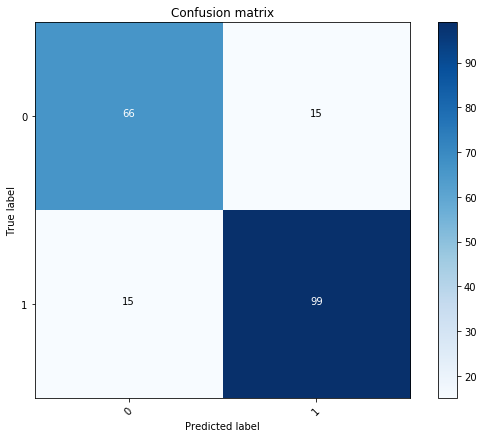

In [50]:
""" Plot confusion matrix """
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(tgt_test, predict_label)
model_utils.plot_confusion_matrix(conf_mat, target_names=["0", "1"])

In [51]:
""" Compute classification metrics """
TP = conf_mat[0][0]
TN = conf_mat[1][1]
FN = conf_mat[0][1]
FP = conf_mat[1][0]
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
print(" Precision: %.2f" % Precision)
print(" Recall: %.2f" % Recall)
print(" F1: %.2f" % (2*Precision*Recall/(Precision+Recall)))
print(" Accuracy: %.2f" % ((TP+TN)/(TP+TN+FP+FN)))

 Precision: 0.81
 Recall: 0.81
 F1: 0.81
 Accuracy: 0.85



**Compare to other models**

- SAF/S: only use news contents (similar to this notebook)
- SAF/A: only use social context
- SAF: combine news contents and social context

<img src="./performance.png" />

#### Inference on 1 sample

In [79]:
test_index = 18
assert test_index<len(src_test)
""" feed 1 sample """
infer_sess.run(infer_model.iterator.initializer, 
               feed_dict={infer_model.src_placeholder: [src_test[test_index]] , 
                          infer_model.batch_size_placeholder: 1})

""" get the predicted log_probabilities """
infer_output = loaded_infer_model.infer(infer_sess)

""" convert to predicted label: 0 for fake news and 1 for real news """
predict_prob = np.exp(infer_output.infer_logprob)
predict_label = [0 if x[0]>=x[1] else 1 for x in predict_prob]

""" print results """
print("--- News ---")
print(vocab.decode(src_test[test_index]))
print("\n--- True: %s -- Predict: %s with confidence: %.2f ---" 
                                      %("Real news" if tgt_test[test_index] else "Fake news",
                                          "Real news" if predict_label[0] else "Fake news",
                                            predict_prob[0][1] if predict_label[0] else predict_prob[0][0]))

--- News ---
<EOS>FormerUS President Barack Obama, in custody of the US military police, has informed on his drug dealing bosses, according to sources in Japanese military intelligence.

As a result of this, an airplane filled with Afghan Heroin and North Korean amphetamines was impounded at Argyle International Airport on St. Vincent and the Grenadines in the Caribbean, the sources say. The money raised from this drug flight was intended to be used to finance the operations of Daesh (formerly known as ISIS), the sources say. This impoundment follows the capture of an Obama linked ship containing 4.2 tons of cocaine, the sources note.

You can see the video below:

This is the developing story.

We will keep you updated soon.

--- True: Fake news -- Predict: Fake news with confidence: 0.83 ---


#### **Attention visualization**

We visualize the contribution of each token at the last encoder layer to the "EOS" token, which is used for the classification.

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

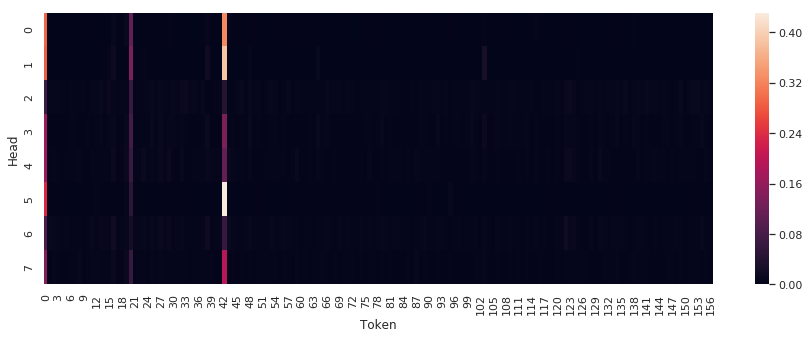

In [80]:
sns.set(rc={'figure.figsize':(15,5)})
ax = sns.heatmap(infer_output.attn_align[-1][0,:,0,:])
plt.xlabel("Token")
plt.ylabel("Head")
plt.show()

Attentions are very sharp at token positions 18-22 and 40-45. We print the texts at those positions.

In [88]:
print("-- Texts in the news content contribute the most to the detection. ")
print(vocab.decode(src_test[test_index][18:22]))
print(vocab.decode(src_test[test_index][40:45]))

-- Texts in the news content contribute the most to the detection. 
his drug dealing bosses
with Afghan Heroin


#### Another sample

In [104]:
test_index = 23
assert test_index<len(src_test)
""" feed 1 sample """
infer_sess.run(infer_model.iterator.initializer, 
               feed_dict={infer_model.src_placeholder: [src_test[test_index]] , 
                          infer_model.batch_size_placeholder: 1})

""" get the predicted log_probabilities """
infer_output = loaded_infer_model.infer(infer_sess)

""" convert to predicted label: 0 for fake news and 1 for real news """
predict_prob = np.exp(infer_output.infer_logprob)
predict_label = [0 if x[0]>=x[1] else 1 for x in predict_prob]

""" print results """
print("--- News ---")
print(vocab.decode(src_test[test_index]))
print("\n--- True: %s -- Predict: %s with confidence: %.2f ---" 
                                      %("Real news" if tgt_test[test_index] else "Fake news",
                                          "Real news" if predict_label[0] else "Fake news",
                                            predict_prob[0][1] if predict_label[0] else predict_prob[0][0]))

--- News ---
<EOS>10:30 pm last night police received a call about gun fire in Miami Gardens.Manager killed 10 employees because they was stealing money and tons of supplies.

--- True: Fake news -- Predict: Fake news with confidence: 0.99 ---


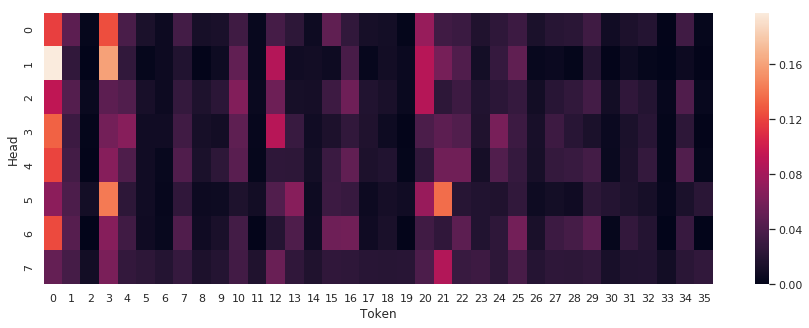

In [105]:
sns.set(rc={'figure.figsize':(15,5)})
ax = sns.heatmap(infer_output.attn_align[-1][0,:,0,:])
plt.xlabel("Token")
plt.ylabel("Head")
plt.show()

Texts contribute equally to the detection!!